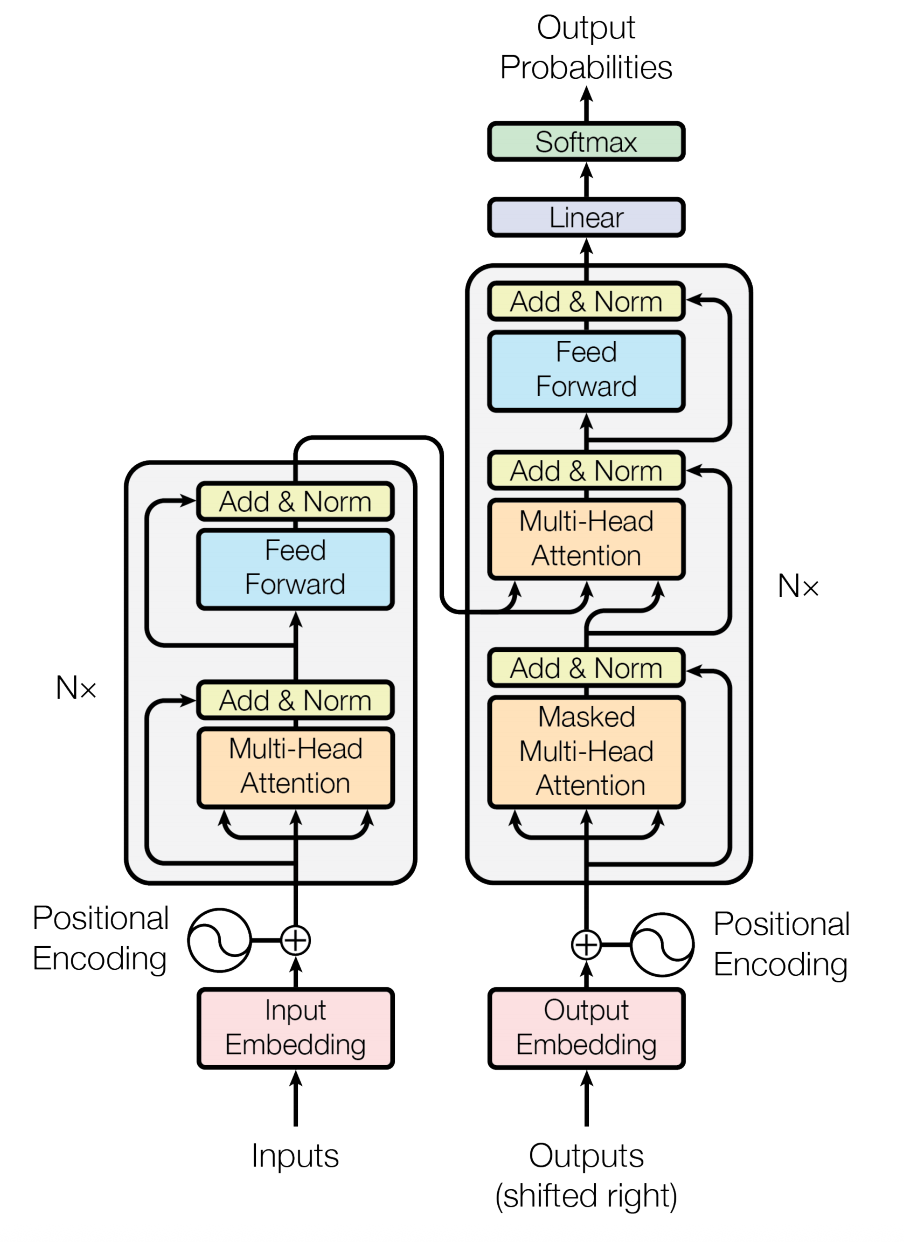

In [2]:
import math
import torch
import torch.nn as nn

# 这就是LLM里的一个transformer block
class SimpleLayerDecoder(nn.Module):
    def __init__(self, hidden_dim, head_num, dropout_rate = 0.1) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.head_num = head_num

        self.head_dim = hidden_dim // head_num
        # MHA需要用的
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.o_proj = nn.Linear(hidden_dim, hidden_dim)
        self.drop_att = nn.Dropout(dropout_rate)
        self.att_ln = nn.LayerNorm(hidden_dim, eps = 1e-7)

        # FFN需要用的
        self.up_proj = nn.Linear(hidden_dim, hidden_dim * 4) # 升维，* 4是GPT的做法
        self.down_proj = nn.Linear(hidden_dim * 4, hidden_dim) # 降维
        self.act_fn = nn.GELU()
        self.drop_ffn = nn.Dropout(dropout_rate)
        self.ffn_ln = nn.LayerNorm(hidden_dim, eps = 1e-7)
    

    def attention_layer(self, query, key, value, attention_mask = None):
        key = key.transpose(2, -1) # (b, head_num, s, head_dim) -> (b, head_num, head_dim, s)
        attention_score = query @ key / math.sqrt(self.head_dim)

        if attention_mask is not None:
            # attention_mask.tril()：生成一个下三角矩阵，
            # 只保留主对角线及其以下的部分（即当前位置及之前的位置），其它位置为 0
            attention_mask = attention_mask.tril()
            attention_score = attention_score.masked_fill(
                attention_mask == 0, float("-inf")
            )
        else:
            attention_mask = torch.ones_like(
                attention_score
            ).tril()
            attention_score = attention_score.masked_fill(
                attention_mask == 0, float("-inf")
            )
        attention_weight = torch.softmax(attention_score, dim=-1)
        attention_weight = self.drop_att(attention_weight) # (b, head_num, s, s)
        output_mid = attention_weight @ value # (b, head_num, s, head_dim)
        output_mid = output_mid.transpose(1, 2).contiguous() # (b, s, head_num, head_dim)
        batch_size, seq_length, _, _ = output_mid.size() 
        # _ 是一个占位符，表示我们不关心这两个维度的具体值，只需要 batch_size 和 seq_length

        output_mid = output_mid.view(batch_size, seq_length, -1) # 这一步就是concat操作
        output = self.o_proj(output_mid)
        return output
    def MHA(self, X, attention_mask = None):
        # (b, s, h) -> (b, head_num, s, head_dim)
        batch_size, seq_length, _ = X.size()
        query = self.query(X).view(batch_size, seq_length, self.head_num, -1).transpose(1, 2)
        key = self.key(X).view(batch_size, seq_length, self.head_num, -1).transpose(1, 2)
        value = self.value(X).view(batch_size, seq_length, self.head_num, -1).transpose(1, 2)
        
        output = self.attention_layer(query, key, value, attention_mask)
        return self.att_ln(X + output)
 
    def FFN(self, X):
        up = self.up_proj(X)
        up = self.act_fn(up)
        down = self.down_proj(up)
        down = self.drop_ffn(down) # dropout
        return self.ffn_ln(X + down) # post layernorm
    
    def forward(self, X, attention_mask = None):
        # X输入 ——> 得到X的batch_size，seq_length ——> 得到Q，K，V ——> 进入attention_layer
        # ——> 计算注意力分数并对下三角部分进行mask ——> softmax得到weight ——> 乘value之后concat
        # 过一个线性层得到output ——> X + output（Add）再Norm，MHA完成 ——> 进入全连接层FFN
        # ——> 升维 ——> 激活（RELU/GELU）——> 降维 ——> dropout ——> X + down（Add）再Norm，FFN完成 
        X = self.MHA(X, attention_mask)
        X = self.FFN(X)  
        return X      
    
class Decoder(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.layer_list = nn.ModuleList(
            [
                SimpleLayerDecoder(64, 8) for _ in range(5) # 5个layer, hidden_dim = 64, head_num = 8
            ]
        )
        self.emb = nn.Embedding(12, 64) # shape:(vocabulary_size, dim)
        self.out = nn.Linear(64, 12)

    def forward(self, X, mask = None):
        X = self.emb(X)
        for _, l in enumerate(self.layer_list):
            X = l(X, mask)
            output = self.out(X)
            return torch.softmax(output, dim=-1)
        
X = torch.randint(low=0, high=12, size=(3, 4)) # X.shape = (b, s)
print(X)
net = Decoder()
mask = torch.tensor(
    [
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 1, 0]
    ]
).unsqueeze(dim=1).unsqueeze(dim=2).repeat(1, 8, 4, 1) # (b, head_num, s, s), mask本来就是3 * 4，所以第一个b和最后一个s不变
print(mask)
net(X)


tensor([[0, 1, 2, 8],
        [3, 7, 4, 4],
        [3, 9, 3, 4]])
tensor([[[[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]]],


        [[[1, 1, 0, 0],
          [1, 1, 0, 0],
          [1, 1, 0, 0],
          [1, 1, 0, 0]],

         [[1, 1, 0, 0],
          [1, 1, 0, 0],
 

tensor([[[0.0669, 0.0832, 0.1032, 0.0818, 0.0634, 0.1836, 0.0628, 0.0355,
          0.1751, 0.0242, 0.0684, 0.0517],
         [0.0749, 0.0531, 0.1367, 0.0249, 0.0796, 0.0837, 0.0682, 0.0859,
          0.0682, 0.1040, 0.1551, 0.0656],
         [0.0232, 0.0715, 0.1492, 0.0340, 0.1113, 0.1182, 0.0445, 0.0914,
          0.1960, 0.0456, 0.0694, 0.0458],
         [0.1073, 0.0994, 0.1072, 0.0376, 0.0479, 0.0744, 0.0814, 0.0785,
          0.0614, 0.1041, 0.1783, 0.0227]],

        [[0.1575, 0.1380, 0.0930, 0.0664, 0.0537, 0.0763, 0.0307, 0.0299,
          0.0779, 0.1437, 0.0557, 0.0773],
         [0.0334, 0.0582, 0.0984, 0.0392, 0.0728, 0.0847, 0.1944, 0.0885,
          0.0895, 0.0540, 0.0737, 0.1132],
         [0.0540, 0.1148, 0.0923, 0.0343, 0.0422, 0.0446, 0.0853, 0.1360,
          0.1027, 0.0282, 0.1473, 0.1183],
         [0.0549, 0.1032, 0.1045, 0.0368, 0.0485, 0.0447, 0.0717, 0.1363,
          0.1028, 0.0276, 0.1398, 0.1294]],

        [[0.1619, 0.1654, 0.0936, 0.0578, 0.0490, 0.0755, 0.